## Calculating Kicks to Semimajor Axis

In this notebook, we simulate a close encounter between planets to determine the "kicks" to the semi-major axis at conjunction. We compare this numerical result with an analytical solution as derived by Namouni et al.

### Namouni's Analytical Result
As found in Namoni et al, the effective potential between two planets can be expanded in powers of eccentricity:

\begin{align}
    W = \sum_{q = -\infty}^{\infty} W_q e^{in(\lambda-\phi)}(-1)^q
\end{align}

The following values were found as the coefficients of this expansion:

In [21]:
W1 = 3.359
W2 = 2.678665722
W3 = 2.639498803
W4 = 2.8559

The kicks to semi-major axis at conjunction can be expressed using these coefficients as follows:

\begin{align}
    \frac{\Delta a_r}{a_0} = -\frac{8}{9} \frac{\mu}{e_c^2} \sum_{q=1}^{\infty} q \tilde{e}^q \sin{(q (\lambda - \varpi))} \lvert W_q \rvert
\end{align}

### Numerical Simulation

In [22]:
# Imports
import matplotlib.pyplot as plt
import rebound
import numpy as np

#### Constants and parameters

The setup consists of two planets in an MMR. We study the Hill approximation, the limit in which the planets are closely spaced and their mass is much smaller than that of the star. In this setup, each planet travels on a slightly eccentric orbit (defined by eccentricity vectors $\vec{e}_1$ and $\vec{e}_2$, where the direction of the vector points toward the pericenter of the orbit). The relative eccentricity is $\vec{e}_{\mathrm{rel}} = \vec{e}_2 - \vec{e}_1$, where the magnitude of this vector is the relative eccentricity $\vec{e}$ and the angle of this vector (taken with respect to the direction in which where the orbits are closest together) is the relative $\varpi$.

In [23]:
## User inputs ##

j, k = 100, 1           # j:j-k MMR
mutot = 3e-12 *125      # (m1 + m2) / mstar
muratio = .5            # mu1 / mutot

theta = 2*np.pi/3       # 

etilde = 0.1
pomega12 = np.pi/2

ecom = 0                # magnitude vector of ecom vector
pomegacom = 0           # angle of ecom vecotr

acom = None             # semimajor axis of COM
Tcom = 1                # period of COM

### Setup

We initialize the simulation so that the conjunction occurs near t=0 and the specified conjunction angle, phi. We also define a function calc_Delta_a to find the change in relative semimajor axis $a$ from before and after the conjunction.

In [24]:
def calc_params(j, k, mutot, muratio, etilde, pomega12, ecom, pomegacom, acom=None, Tcom=None):
    ''' Given user inputs, calculates parameters needed to set up the simulation
        Args: 
            j: ??
            k: order of the resonance (ie for 100:99 resonance, order=1)
            mutot: total mass ratio of the planets, (mu1 + mu2) / Mstar
            muratio: ratio of inner planet mass to total planetary mass, m1/(m1 + m2)
            etilde: e12/ec, magnitude of the relative eccentricity vector / crossing eccentricity
            pomega12: angle of the relative eccentricity vector e12
            ecom: magnitude of center of mass eccentricity vector
            pomegacom: angle of center of mass eccentricity vector
            acom: semimajor axis of the center of mass between planets
            Tcom: period of the center of mass between planets
        Returns:
            e1: eccentricity of inner planet
            e2: eccentricity of outer planet
            mu1: mass of inner planet
            mu2: mass of outer planet
            pomega1: pomega of inner planet (ie location angle of pericenter)
            pomega2: pomega of outer planet (ie location angle of pericenter)
            T1: period of inner planet
            T2: period of outer planet
            n10: initial mean motion of inner planet
            n20: initial mean motion of outer planet
            tconj: time between conjunctions
            epsilon: small mass parameter (1/3*mutot)**(1/3)
    '''
    #eccentricity
    ec = 2*k/3/j            # crossing eccentricity
    e12=etilde*ec

    # eccentricity vectors
    e12_vec = e12 * np.exp(1j * pomega12)
    ecom_vec = ecom * np.exp(1j * pomegacom)

    e2_vec = muratio*e12_vec + ecom_vec
    e1_vec = e2_vec - e12_vec

    # planet 1
    e1, pomega1 = np.abs(e1_vec), np.angle(e1_vec)
    mu1 = muratio * mutot    # m1/m_star

    # planet 2
    e2, pomega2 = np.abs(e2_vec), np.angle(e2_vec)
    mu2 = mutot-mu1          # m2/m_star

    # periods
    if Tcom and acom:
        print('Both acom and Tcom specified. \n Used acom = {}'.format(acom))
    elif Tcom: # if specifying Tcom
        T1 = Tcom * (mutot)**(3/2) / (mu1 + mu2*(j/(j-k))**(2/3))**(3/2)
        T2 = T1*j/(j-k)
    elif Tcom:# if defining acom
        T1 = (acom*mutot*(1/(mu1 + mu2*(j/(j-k))**(2/3))))**(3/2)
        T2 = T1*j/(j-k)
    else: raise Exception('Must specify acom or Tcom')

    # mean motions
    n10 = 2*np.pi/T1        # initial mean motion of inner planet
    n20 = 2*np.pi/T2        # initial mean motion of outer planet

    tconj=(j-k)/k*T1           # time between conjunctions
    epsilon = (mutot/3)**(1/3) # small mass parameter

    return e1, e2, mu1, mu2, pomega1, pomega2, T1, T2, n10, n20, tconj, epsilon


def gen_setup(t0, input_vec, correction, theta, etilde, to_print=True): # make sim with sim.t = t0 (where conjunction always happens near t=0, use get_conjunction_time to get exact)
    ''' Creates rebound simulation for two planets with the specified masses and eccentricities
        where conjunction occurs near t=0 and the specified angle phi
        Args:
            t0: initial time (ie -.5*t_conj if integrating from -.5*t_conj to +.5*tconj)
            input_vec: output from calc_param function
                       j, k, mutot, muratio, theta, etilde, pomega12, ecom, pomegacom, acom, Tcom
            correction: adjustment added to the input phi value so that simulated phi is closer
                        to the desired input value, obtained from calculate_phi_correction 
            theta: angle of conjunction relative to reference angle pomega12 (theta = l_conj - pomega12)
            etilde: e12/ec, magnitude of the relative eccentricity vector / crossing eccentricity
            to_print: if True, prints the Hill radius separation
    '''
    param_vec = calc_params(*input_vec)
    e1, e2, mu1, mu2, pomega1, pomega2, T1, T2, n10, n20, tconj, epsilon = param_vec
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1)
    sim.add(m=mu1, P=T1, e=e1, pomega=pomega1,
            l=pomega12+(theta-correction)+n10*t0) # theta = l - pomega12, so l = pomega12+theta
    ps = sim.particles
    theta20 = pomega12+(theta-correction)+n20*t0  # initial angle of planet 2 (outer planet)
    sim.add(m=mu2, P=T2, e=e2, pomega=pomega2, l=theta20)
    sim.t = t0
    
    if to_print:
        print('Hill radius separation:', (sim.particles[2].a-sim.particles[1].a)/(mutot/3)**(1/3)) # , sim.particles[1].l
    return sim

def calc_theta_correction(input_vec, theta, etilde, tmin, tmax, Nout, iterations=3, to_print=False):
    ''' returns a correction to the input theta value, theta_0, so that the simulated theta value from the 
        setup function, theta_sim, matches theta_0.
        Args:
            theta_0: desired theta value (angle of conjunction theta = l_conj - pomega12)
            etilde: relative eccentricity magnitude / crossing eccentricity
            tmin: initial time of integration
            tmax: final time of integration
            Nout: number of timesteps in the integration
            iterations: number of corrective iterations to perform
            to_print: if True, prints the input and simulated theta values
    '''
    #initializing
    correction = 0
    theta_err = 0

    # iterate to correct for theta value
    for iteration in range(iterations):
        # set up simulation
        theta_input = theta - correction # theta value that goes into sim
        sim = gen_setup(t0=tmin, input_vec=input_vec, correction=correction, theta=theta_input, etilde=etilde, to_print=False)
        ps = sim.particles

        # integrate through conjunction
        dl, theta_arr = np.zeros(Nout), np.zeros(Nout)
        times = np.linspace(tmin, tmax, Nout)
        for i, time in enumerate(times):
            sim.integrate(time)
            dl[i] = unwrap_l(ps)
            theta_arr[i] = ps[2].l - ps[2].pomega

        # find simulated theta conjunction, compare to input vlaue
        conj_idx = np.argmin(np.abs(dl))
        correction = theta_arr[conj_idx] - theta_input
        theta_err = theta_arr[conj_idx] - theta

    if to_print:
        print('{:9}: {}'.format('Input theta', theta))
        print('{:9}: {}'.format('Sim theta', theta_arr[conj_idx]))
        
    return correction, theta_err # (correction angle and the deviation from the actual theta)

def calc_Delta_a(da_list, conj_idx):
    '''returns change in da from before to after conjunction given list of a values 
       throughout conj'''
    da0_max_idx = np.argmax(da_list[:conj_idx]) # max value of a before conjunction, 
                                              # corresponds to peak just before conj

    daf_max_idx = (np.argmax(da_list[conj_idx:]) # max value of a after conjunction 
                   + conj_idx)                    

    da0 = np.mean(da_list[:da0_max_idx])
    daf = np.mean(da_list[daf_max_idx:])

    Delta_a = daf-da0

    return Delta_a, da0, daf

def unwrap_l(ps):
    ''' given a sim.particles object ps, returns relative lambda (l) value of the planets
        removing the 2*pi discontinuities that result when one planet has crossed l=0 but
        the other has not
    '''
    if ps[2].l - ps[1].l > np.pi:
        return ps[2].l - ps[1].l - 2*np.pi
    elif ps[2].l - ps[1].l < -np.pi:
        return ps[2].l - ps[1].l + 2*np.pi
    else:
        return ps[2].l - ps[1].l

As an example, we can integrate through a close encounter event and plot the semimajor axis throughout this process to visualize the kick it experiences at conjunction.

0.0003333333333333333
0.0003333333333333333
Hill radius separation: 13.400397798958291
-1.7823891881232207e-06


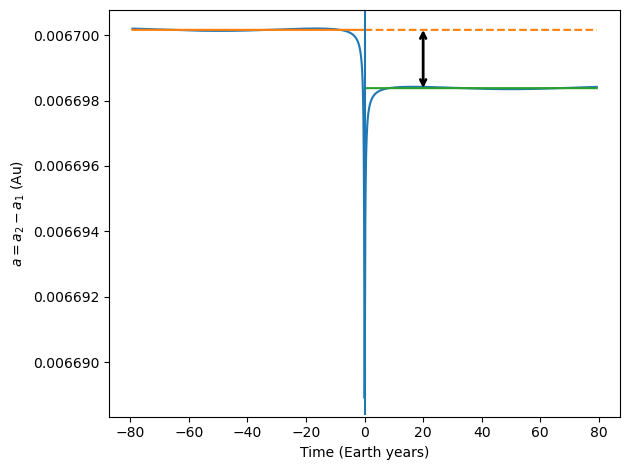

In [29]:
Nout = 10000
int_time_factor = .805
input_vec = j, k, mutot, muratio, etilde, pomega12, ecom, pomegacom, acom, Tcom

def run(input_vec, Nout, int_time_factor):
    param_vec = calc_params(*input_vec)
    e1, e2, mu1, mu2, pomega1, pomega2, T1, T2, n10, n20, tconj, epsilon = param_vec

    tmin = -int_time_factor*tconj
    tmax = int_time_factor*tconj  
    correction, theta_err = calc_theta_correction(input_vec, theta, etilde, tmin, tmax, Nout, iterations=2)
    sim = gen_setup(t0=tmin, input_vec=input_vec, correction=correction, theta=theta, etilde=etilde)
    ps = sim.particles

    da, dl, theta_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(tmin, tmax, Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        da[i] = ps[2].a - ps[1].a
        dl[i] = unwrap_l(ps) 
        theta_arr[i] = ps[2].l - ps[2].pomega # FIXME to be relative to pomega 12!!
    
    # conjunction index, angle at conjunction
    conj_idx = np.argmin(np.abs(dl))
    Delta_a, da0, daf = calc_Delta_a(da, conj_idx)

    return times, da, dl, theta_arr, conj_idx, da0, daf, Delta_a

times, da, dl, theta_arr, conj_idx, da0_plot, daf_plot, Delta_a = run(input_vec, Nout, int_time_factor)

# plot da throughout encounter
fig, ax = plt.subplots()
ax.plot(times, da)
t_before_conj = times[:conj_idx]
t_after_conj = times[conj_idx:]
ax.plot(t_before_conj, np.ones_like(t_before_conj)*da0_plot, label='pre-conjunction')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*da0_plot, c='C1', linestyle='--')
ax.plot(t_after_conj, np.ones_like(t_after_conj)*daf_plot, label='post-conjunction')
ax.axvline(times[conj_idx], da[conj_idx]) # conjunction location
ax.annotate('$a_i={:.4e}$'.format(da0_plot), (-70, .006722))
ax.annotate('$a_f={:.4e}$'.format(daf_plot), (20, .006720))
ax.annotate("", (20, da0_plot), (20, daf_plot), arrowprops={'arrowstyle':'<->','shrinkA':0, 'shrinkB':0,'linewidth':2, 'color':'black'})
ax.annotate('$\Delta a={:.4e}$'.format(da0_plot-daf_plot), (22, .0067217))
ax.set(xlabel='Time (Earth years)', ylabel='$a = a_2 - a_1$ (Au)') #title='Evolution of Relative Semimajor Axis during Conjunction')
#ax.legend()
fig.tight_layout()
fig.savefig('delta_a.pdf')

print(daf_plot-da0_plot)

We repeat this process for a range of initial eccentricity values for the test particle's orbit and compare the numerical simulation result to Namoni's result.

In [32]:
Nout = 100000 # num time steps in integration
N = 10 #
etilde_list = np.linspace(0.001, .2, N)
a_kicks, paper_1, paper_2, paper_3, paper_4 = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
for idx, etilde in enumerate(etilde_list):
    input_vec[4] = etilde # FIXME
    j, k, mutot, muratio, etilde, pomega12, ecom, pomegacom, acom, Tcom = input_vec
    ec = 2*k/3/j
    
    times, da, dl, theta_arr, conj_idx, da0, daf, Delta_a = run(input_vec, Nout, int_time_factor)
    
    #delta_a = daf - da0
    a_kicks[idx] = Delta_a / acom

    # Namouni solution
    paper_1[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1) # 1st order approx
    paper_2[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2) # 2nd order approx
    paper_3[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta)) # 3rd order approx
    paper_4[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta) + 4*W4*etilde**4*np.sin(4*theta)) # 4th order approx

TypeError: 'tuple' object does not support item assignment

In [37]:
Nout = 100000 # num time steps in integration
N = 10 #
etilde_list = np.linspace(0.001, .2, N)
a_kicks, paper_1, paper_2, paper_3, paper_4 = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
for idx, etilde in enumerate(etilde_list):
    #setup
    correction, theta_err = calc_theta_correction(theta, etilde, tmin, tmax, Nout, iterations=2)
    sim = setup(t0=tmin, correction=correction, theta=theta, etilde=etilde)
    ps = sim.particles

    # integration
    da, dl, theta_arr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(tmin, tmax, Nout)
    for i, time in enumerate(times):
        sim.integrate(time)
        da[i] = ps[2].a - ps[1].a
        dl[i] = unwrap_l(ps) # removes 2*pi jumps in dl
        theta_arr[i] = ps[2].l - ps[2].pomega #FIXME: change to rel pomega
     
    # conjunction index, angle at conjunction
    conj_idx = np.argmin(np.abs(dl))
    theta = theta_arr[conj_idx] # angle at conjunction

    # n-body solution
    Delta_a, da0, daf = calc_Delta_a(da, conj_idx)
    
    #delta_a = daf - da0
    a_kicks[idx] = Delta_a / ps[1].a

    # Namouni solution
    paper_1[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1) # 1st order approx
    paper_2[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2) # 2nd order approx
    paper_3[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta)) # 3rd order approx
    paper_4[idx] = -8/9 * mutot / ec**2 * (etilde*np.sin(theta)*W1 + 2*etilde**2*np.sin(2*theta)*W2 + 3*W3*etilde**3*np.sin(3*theta) + 4*W4*etilde**4*np.sin(4*theta)) # 4th order approx

Hill radius separation: 13.400397798957403
Hill radius separation: 13.400397798958736
Hill radius separation: 13.40039779895807
Hill radius separation: 13.400397798957625
Hill radius separation: 13.400397798957625
Hill radius separation: 13.400397798957181
Hill radius separation: 13.400397798957403
Hill radius separation: 13.400397798955627
Hill radius separation: 13.400397798958513
Hill radius separation: 13.400397798958958


Comparison of results from Namouni and n-body simulation:

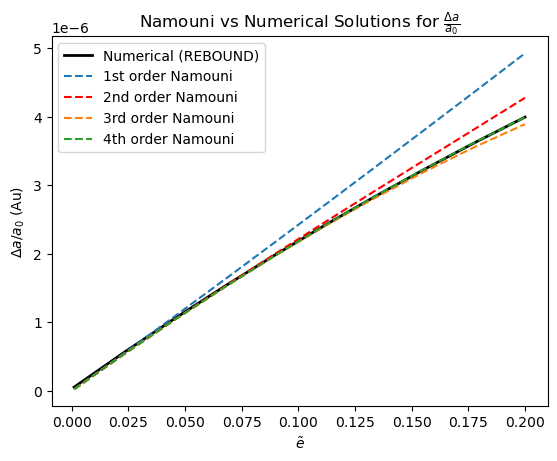

In [38]:
fig, ax = plt.subplots()
ax.plot(etilde_list, a_kicks, 'k-', linewidth=2, label='Numerical (REBOUND)')
ax.plot(etilde_list, paper_1, '--', label='1st order Namouni')
ax.plot(etilde_list, paper_2, '--', label='2nd order Namouni', c='red')
ax.plot(etilde_list, paper_3, '--', label='3rd order Namouni')
ax.plot(etilde_list, paper_4, '--', label='4th order Namouni')
ax.set(xlabel="$\\tilde{e}$", ylabel='$\Delta a$/$a_0$ (Au)', title='Namouni vs Numerical Solutions for $\\frac{\Delta a}{a_0}$')

ax.legend()
#fig.savefig('comp_plot.pdf') # pdf
#fig.savefig('comp_plot.png', dpi=300) # png


In [28]:
param_vec = calc_params(j, k, mutot, muratio, etilde, pomega12, ecom, pomegacom, Tcom=Tcom)
e1, e2, mu1, mu2, pomega1, pomega2, T1, T2, n10, n20, tconj, epsilon = param_vec

print(e1)

0.0003333333333333333
